+ Reference : https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/blob/main/NICE_Non_linear_Independent_Components_Estimation

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import mnist
import matplotlib.pyplot as plt

from torch.distributions.transformed_distribution import TransformedDistribution
from torch.distributions.uniform import Uniform
from torch.distributions.transforms import SigmoidTransform
from torch.distributions.transforms import AffineTransform

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load MNIST dataset

In [2]:
torch.manual_seed(0)

# load (and normalize) mnist dataset
(trainX, trainY), (testX, testY) = mnist.load_mnist(normalize=False, flatten=False)
trainX = (np.float32(trainX) + torch.rand(trainX.shape).numpy()) / 255.
trainX = trainX.clip(0, 1)
trainX = torch.tensor(trainX.reshape(-1, 28 * 28))

In [3]:
trainX.size()

torch.Size([60000, 784])

# Define Standard Logistic Distribution

In [4]:
class StandardLogisticDistribution:

    def __init__(self, data_dim=28 * 28, device='cpu'):
        self.m = TransformedDistribution(
            Uniform(torch.zeros(data_dim, device=device),
                    torch.ones(data_dim, device=device)),
            [SigmoidTransform().inv, AffineTransform(torch.zeros(data_dim, device=device),
                                                     torch.ones(data_dim, device=device))]
        )

    def log_pdf(self, z):
        return self.m.log_prob(z).sum(dim=1)

    def sample(self):
        return self.m.sample()

# Define NICE

In [5]:
class NICE(nn.Module):

    def __init__(self, data_dim=28 * 28, hidden_dim=1000):
        super().__init__()

        self.m = torch.nn.ModuleList([nn.Sequential(
            nn.Linear(data_dim // 2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, data_dim // 2), ) for i in range(4)]) # 논문에서 4개의 block 사용
        self.s = torch.nn.Parameter(torch.randn(data_dim))

    def forward(self, x):
        x = x.clone()
        for i in range(len(self.m)):
            
            # x를 x_1, x_2 로 split 하는 부분
            x_i1 = x[:, ::2] if (i % 2) == 0 else x[:, 1::2]  # 짝수 인덱스
            x_i2 = x[:, 1::2] if (i % 2) == 0 else x[:, ::2]  # 홀수 인덱스
            
            h_i1 = x_i1
            h_i2 = x_i2 + self.m[i](x_i1)  # y_2 = x_2 + m(x_1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = h_i1
            x[:, 1::2] = h_i2
        z = torch.exp(self.s) * x
        log_jacobian = torch.sum(self.s)
        return z, log_jacobian

    def invert(self, z):
        x = z.clone() / torch.exp(self.s)
        for i in range(len(self.m) - 1, -1, -1):
            h_i1 = x[:, ::2]
            h_i2 = x[:, 1::2]
            x_i1 = h_i1
            x_i2 = h_i2 - self.m[i](x_i1)   # inverse는 빼기(-)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = x_i1 if (i % 2) == 0 else x_i2
            x[:, 1::2] = x_i2 if (i % 2) == 0 else x_i1
        return x

# Define Train

+ nomralizing_flow : NICE()       
+ optimizer : Adam(lr=0.0002, weight_decay=0.9)       
+ distribution : logistic distribution

In [6]:
def training(normalizing_flow, optimizer, dataloader, distribution, nb_epochs=1500, device='cpu'):
    training_loss = []
    for _ in tqdm(range(nb_epochs)):

        for batch in dataloader:
            z, log_jacobian = normalizing_flow(batch.to(device))
            log_likelihood = distribution.log_pdf(z) + log_jacobian
            loss = -log_likelihood.sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())

    return training_loss

100%|███████████████████████████████████████████████████████████████████████████████████████| 500/500 [3:49:27<00:00, 27.54s/it]


<Figure size 1000x1000 with 0 Axes>

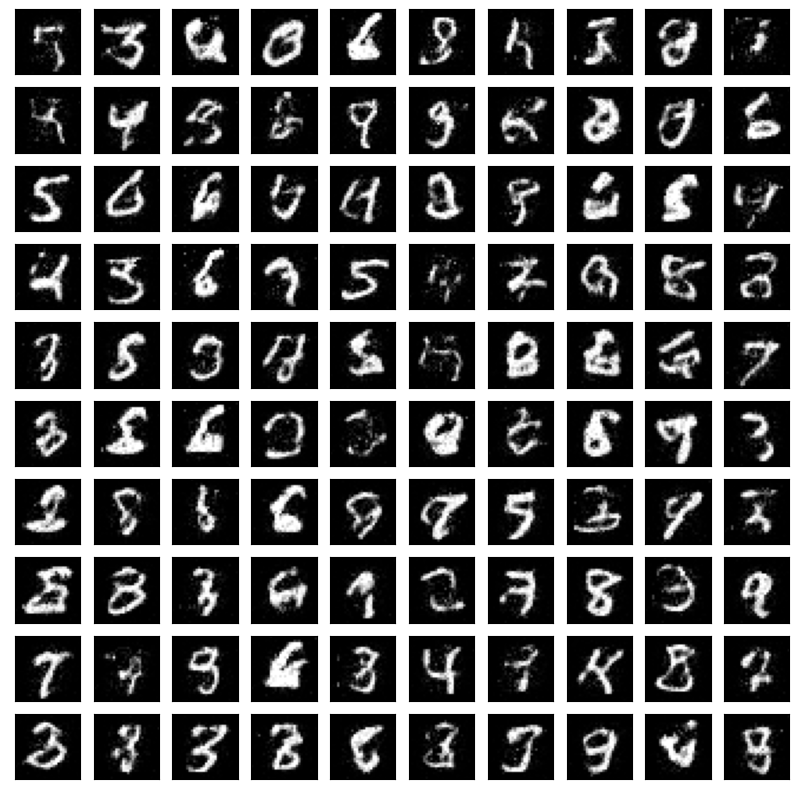

In [7]:
if __name__ == '__main__':
    
    plt.figure(figsize=(10, 10))
    
    normalizing_flow = NICE().to(device)
    logistic_distribution = StandardLogisticDistribution(device=device)
    x = torch.randn(10, 28 * 28, device=device)
    assert torch.allclose(normalizing_flow.invert(normalizing_flow(x)[0]), x, rtol=1e-04, atol=1e-06)
    optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
    dataloader = DataLoader(trainX, batch_size=32, shuffle=True)
    training_loss = training(normalizing_flow, optimizer, dataloader, logistic_distribution, nb_epochs=500,
                             device=device)

    nb_data = 10
    fig, axs = plt.subplots(nb_data, nb_data, figsize=(10, 10))
    for i in range(nb_data):
        for j in range(nb_data):
            x = normalizing_flow.invert(logistic_distribution.sample().unsqueeze(0)).data.cpu().numpy()
            axs[i, j].imshow(x.reshape(28, 28).clip(0, 1), cmap='gray')
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
    # plt.savefig('Imgs/Generated_MNIST_data.png')
    plt.show()